In [1]:
#%load_ext autoreload
#%autoreload 2

import os
import numpy as np 
from multiprocessing import Pool
import time 
import random
import IPython.display as ipd
import pyaudio
import sys
import librosa
import librosa.display
from tqdm import tqdm
from matplotlib import pyplot as plt
sys.path.append('../../')

import pdb
#import utils.audio as a
#import utils.plots as plots
import utils as utils

/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Load audio files into dataset

In [2]:
# load (fe)male audio sequences without alpha, beta 
PATH = '../../datasets/freesound.org/wav_denoised/'
SR = 22050 

dataset = []

files = os.listdir(PATH)

for f in tqdm(files):
    if f.split('.')[-1] != 'wav':
        continue
    #pdb.set_trace()
    audio, sr = utils.audio.loadAudio(PATH + f, sr=SR)
    dataset.append(audio)

100%|██████████| 384/384 [00:00<00:00, 2312.59it/s]


In [3]:
dataset = np.array(dataset)
len(dataset[0])

51237

In [4]:
# read data
data = utils.misc.slidingWindow(dataset, int(SR*1), int(SR*1))

In [4]:
# create chunks
dataset_chunks = []
chunk_sz = int(SR*.2)
for chunk in dataset:
    #pdb.set_trace()
    dataset_chunks.append(utils.misc.slidingWindow(chunk, chunk_sz, chunk_sz))


In [5]:
# concatenate chunks
chunks = np.array(dataset_chunks)
chunks = np.concatenate((chunks[:]), axis=0)
chunks.shape

(16073, 4410)

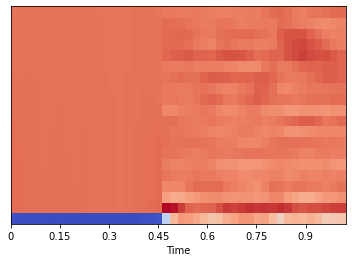

In [7]:
# mfcc 
#inp = chunks[np.random.randint(1000), np.random.randint(10)]
inp = chunks[np.random.randint(1000), :]
mfccs = librosa.feature.mfcc(y=inp, sr=SR, n_mfcc=20) #has quite a bunch of parameters
librosa.display.specshow(mfccs, sr=SR, x_axis='time')
ipd.Audio(inp, rate=SR)

(12, 44)


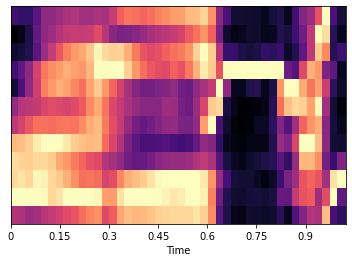

In [60]:
#chroma
chroma_cq = librosa.feature.chroma_cqt(y=inp, sr=SR, hop_length=512)

#y=None, sr=22050, C=None, hop_length=512, fmin=None, norm=inf, threshold=0.0, tuning=None, n_chroma=12, n_octaves=7, window=None, bins_per_octave=36, cqt_mode='full')[source]

print(chroma_cq.shape)
librosa.display.specshow(chroma_cq, sr=SR, x_axis='time')

In [69]:
# RMS mag spec
print(librosa.feature.rms(y=inp).shape)

# Spectral centroid
print(librosa.feature.spectral_centroid(y=inp, sr=SR).shape)

# Spectral bandwidth
print(librosa.feature.spectral_bandwidth(y=inp, sr=SR).shape)

# Spectral flatness
print(librosa.feature.spectral_flatness(y=inp).shape)

# spectral rolloff
print(librosa.feature.spectral_rolloff(y=inp, sr=SR).shape)

# zero crossing rate 
print(librosa.feature.zero_crossing_rate(inp).shape)

(1, 44)
(1, 44)
(1, 44)
(1, 44)
(1, 44)
(1, 44)


(7, 44)


/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


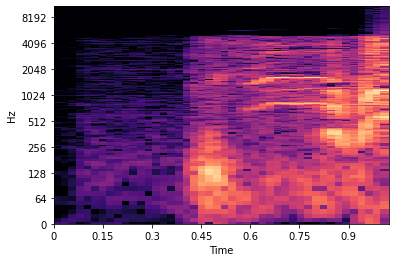

In [65]:
# Spectral contrast

S = np.abs(librosa.stft(inp))
spec_contrast = librosa.feature.spectral_contrast(S=S, sr=sr)
print(spec_contrast.shape)
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), y_axis='log', x_axis='time')

In [68]:
# Tonnetz
y = librosa.effects.harmonic(inp)
tonnetz = librosa.feature.tonnetz(y=y, sr=SR)
print(tonnetz.shape)

(6, 44)


(384, 44)
(32, 44)


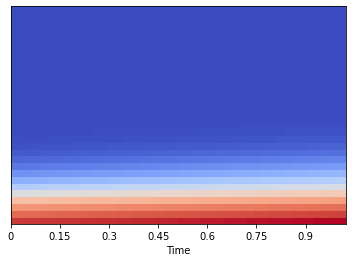

In [87]:
# local and global tempogram
hop_length = 512
oenv = librosa.onset.onset_strength(y=inp, sr=SR, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=SR,
                                      hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                           hop_length=hop_length)[0]

from skimage.transform import resize
bottle_resized = resize(tempogram, (32, 44))
print(tempogram.shape)
print(bottle_resized.shape)
#librosa.display.specshow(tempogram, x_axis='time')
librosa.display.specshow(bottle_resized, x_axis='time')

In [98]:
from skimage.transform import resize

num_points = 1000
num_feats = 20
num_chunks = chunks.shape[0]
hop_length = 512
X = np.zeros((num_chunks, 44*(13 + 12 + 1 + 1 + 1 + 1 + 1 + 1 + 7 + 6 + 32) + 1)) # 13 mfcc, 12 chroma, 
for i in tqdm(range(num_chunks)):
    #pdb.settrace()
    # mfcc
    feat = librosa.feature.mfcc(y=chunks[i, :], sr=SR, n_mfcc=num_feats)[1:14].flatten() # 13x44
    # chroma
    chroma_cq = librosa.feature.chroma_cqt(y=chunks[i, :], sr=SR, hop_length=hop_length).flatten() #12x44
    # RMS mag spec
    rms = librosa.feature.rms(y=chunks[i, :]).flatten() #1x44
    # Spectral centroid
    cent = librosa.feature.spectral_centroid(y=chunks[i, :], sr=SR).flatten()#1x44
    # Spectral bandwidth
    band = librosa.feature.spectral_bandwidth(y=chunks[i, :], sr=SR).flatten()#1x44
    # Spectral flatness
    flat = librosa.feature.spectral_flatness(y=chunks[i, :]).flatten()#1x44
    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(y=chunks[i, :], sr=SR).flatten()#1x44
    # zero crossing rate 
    zcross = librosa.feature.zero_crossing_rate(chunks[i, :]).flatten()#1x44
    # Spectral contrast
    S = np.abs(librosa.stft(chunks[i, :]))
    spec_contrast = librosa.feature.spectral_contrast(S=S, sr=SR).flatten() #7x44
    # Tonnetz
    y = librosa.effects.harmonic(chunks[i, :])
    tonnetz = librosa.feature.tonnetz(y=y, sr=SR).flatten() #6x44
    # local and global tempogram    
    oenv = librosa.onset.onset_strength(y=chunks[i, :], sr=SR, hop_length=hop_length)
    tempogram = resize(librosa.feature.tempogram(onset_envelope=oenv, sr=SR, hop_length=hop_length), (32, 44)) #32x44
    # Compute global onset autocorrelation
    ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    ac_global = librosa.util.normalize(ac_global)
    # Estimate the global tempo for display purposes
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    #pdb.set_trace()
    X[i, :] = np.concatenate((feat, chroma_cq, rms, cent, band, flat, rolloff, zcross, spec_contrast, tonnetz, tempogram.flatten(), tempo.reshape(1)))

  2%|▏         | 61/3075 [00:13<10:56,  4.59it/s]/opt/anaconda3/envs/aip37/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 3075/3075 [11:19<00:00,  4.53it/s]


In [108]:
np.save("feature_space.npy", X)

In [8]:
X = np.load("feature_space.npy")
X.shape

(3075, 3345)

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

new_X = StandardScaler().fit_transform(X)

new_X = X

pca = PCA(n_components=128)
#pca_X = pca.fit_transform(new_X)

pca_X = new_X

In [10]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=64, verbose=2).fit(pca_X)
labels = gmm.predict(pca_X)

Initialization 0
Initialization converged: True	 time lapse 506.00775s	 ll 18808.46868


(3075,)


(array([322., 270., 375., 319., 192., 193., 434., 458., 260., 252.]),
 array([ 0. ,  6.3, 12.6, 18.9, 25.2, 31.5, 37.8, 44.1, 50.4, 56.7, 63. ]),
 <BarContainer object of 10 artists>)

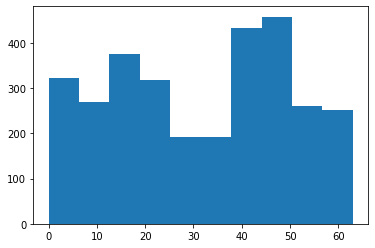

In [11]:
print(labels.shape)
plt.hist(labels)
#print(labels[1000:2000])

In [12]:
#%matplotlib inline
#pca_scaled_X = StandardScaler().fit_transform(pca_X)
pca_scaled_X = pca_X
plot_X = PCA(n_components=3).fit_transform(pca_scaled_X)

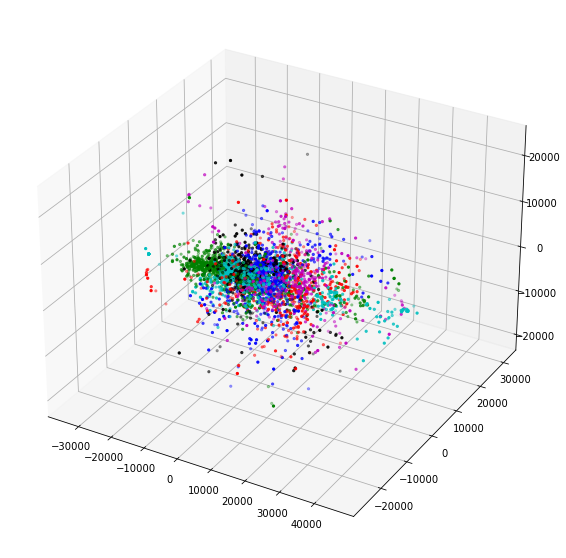

In [16]:
%matplotlib inline
colors = ['r', 'b', 'g', 'm', 'k', 'c']
fig1 = plt.figure(figsize=[20, 10])
ax1 = fig1.add_subplot(111, projection='3d')
for i in range(64):
    ax1.scatter(plot_X[labels==i, 0], plot_X[labels==i, 1], plot_X[labels==i, 2], c=colors[i%6], s=5.);
plt.show()

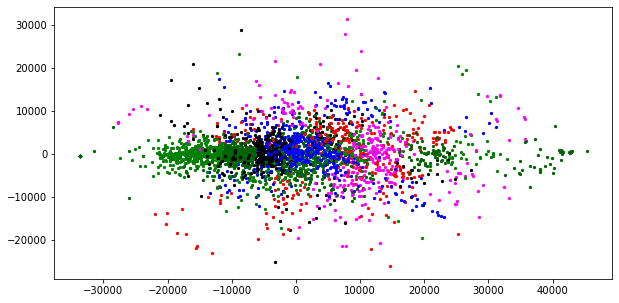

In [17]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_scaled_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(64):.-+
    ////////////////////////////////////////////////////////////////////
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i%6], s=5);
plt.show()
#plt.savefig('mfcc_spectral_features.png')

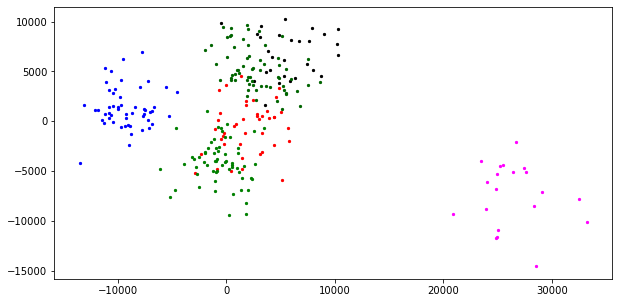

In [15]:
#%matplotlib inline
plot_X2 = PCA(n_components=2).fit_transform(pca_X)
colors = ['red', 'blue', 'green', 'magenta', 'black', 'darkgreen', 'orange', 'crimson', 'grey'] #'cyan',
fig2 = plt.figure(figsize=[10, 5])
ax2 = fig2.add_subplot(111)
for i in range(6):
    ax2.scatter(plot_X2[labels==i, 0], plot_X2[labels==i, 1], c=colors[i], s=5);
plt.show()

In [155]:
target = 0
idx = np.where(labels==target)[0][0]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][5]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][10]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][15]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][20]
display(ipd.Audio(chunks[idx, :], rate=SR))

idx = np.where(labels==target)[0][30]
display(ipd.Audio(chunks[idx, :], rate=SR))


0


In [149]:
idx = np.where(labels==target)[0][10]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [150]:
idx = np.where(labels==target)[0][20]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1


In [151]:
idx = np.where(labels==target)[0][30]
print(labels[idx])
#i = idx // num_chunks
#j = idx % num_chunks
ipd.Audio(chunks[idx, :], rate=SR)

1
